>>>>> # MLND Capstone Project


>>> # Sentiment Classification with IMDB Dataset


# Definition

### Project Overview

Sentiment Classification is a common task in the field of Natural Language Processing, it is about extracting the sentiment of a person given a text they wrote as input.

Extracting sentiment from text can lead to build more intelligent systems acting according to those sentiments like chatbots or smart assistants.

Although this task is considered a complex task even for humans due to absence of facial expressions and voice tones in text but it is fairly much easier when given a paragraph of more of text written for the purpose of delivering sentiment such as the case with movie reviews.

The dataset was constructed back in 2011 by Andrew L. Mass et al. in the paper “Learning Word Vectors for Sentiment Analysis”, was a Kaggle challenge in 2016 and considered a Sentiment Analysis benchmark.
Another Dataset used for this task is "Rotten Tomatoes" Dataset.


### Problem Statement

Given the 50k labeled IMDB movie reviews in text format it is required to extract the sentiment and classify each review (from the 25k test set) to be either positive or negative, then compare the predicted results to the real labels and output the classification accuracy.

The problem is to be solved by extracting features out of blocks of text (reviews) and mapping feature values and combinations to either positive or negative sentiment classes through the usage of a couple of Supervised Machine Learning Algorithms (Logistic regression and Naive Bayes), Also some text preprocessing will be done (lemmatization,stop-words removal,punctuation removal ..etc) to facilitate and improve quality of extracted features.


### Evaluation Metrics

The metric used to evaluate the model is the Accuracy because it is a classification task and all we care about is whether or not the model can extract the sentiment from the reviews correctly.

So we determine how well the model is performing by finding the percentage of the correctly predicted labels.

Accuracy= (number of correct labels) / (total number of labels) * 100%

# Analysis

### Data Exploration

The IMDB movie review dataset was first proposed by Maas et al.in ”Learning Word Vectors for Sentiment Analysis” as a benchmark for sentiment analysis.

The dataset consists of 100K IMDB movie reviews and each review has several sentences.
The 100K reviews are divided into three datasets: 25K labeled training instances, 25K
labeled test instances and 50K unlabeled training instances. Each review consists of several sentences of text in a file and has one label representing its sentiment: Positive or Negative. These labels are balanced in both
the training and the test set.

The dataset can be obtained from : http://ai.stanford.edu/~amaas/data/sentiment/

I will use the 50k labeled section of the dataset to train my supervised learning model.

#### Imports and requirements

The following cell should be uncommented at the first run to make sure all needed libraries for the project and packages are installed (assuming user has Jupyter Notebooks installed and all default ML libraries like numpy and sklearn)

In [2]:
# !python3 -m pip install -U stop-words
# !python3 -m pip install -U nltk
# !python3 -m pip install -U gensim
# !python3 -m pip install -U bs4
# !python3 -m pip install -U tqdm
#!python3 -m pip install -U seaborn
# import nltk
# nltk.download('popular')
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
#Natural Language Toolkit : a famous python lib for text processing
import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
import numpy as np
#BeautifulSoup used for text cleaning (removing HTML tags here)
from bs4 import BeautifulSoup
#Glob for dealing with files and directories
import glob
from functools import reduce
import operator
#tqdm for progress bars
from tqdm import tqdm

#### Downloading dataset,extracting compressed files

This cell should be uncommented on first run to download dataset to the directory and uncompress it.

In [4]:
# !rm -rf datalab
# !wget -c http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !ls
# !uncompress aclImdb_v1.tar.gz
# !tar -xvf aclImdb_v1.tar
# !rm aclImdb_v1.tar
# !ls

** Exploratory Visualization ** is done by printing samples when reading files and file names to explore the dataset and its contents.

Visualization is also done throughout the whole notebook by printing samples of results after each processing step to ensure correctness and for better readability.Also 

** Benchmark: ** 

A good benchmark to see whether a machine-learning solution works or not is random chance.

Given that the data is evenly split and the 25k test data is composed of 12.5 k positive samples and 12.5k negative samples then a random chance classifier will give a ** 50% ** accuracy,
so my model must outperform this percentage in order to be effective.

Another historical benchmark to compare my solution to is the paper mentioned before and in the Credits section buy Andrew Mass : the highest classification accuracy was ** 88.89% ** on this dataset.
So an efficient model will give close numbers or outperform it.


# Methodology

** Data Preprocessing: ** removing HTML tags,removing stop-words and punctutations,and finally lemmatization.

** Implementation: ** Feature extraction using TF-IDF, preparing training and testing data and then Supervised Learning using Logistic Regression and Naive Bayes.

** Refinement: ** hyperparameter tuning of Logistic Regression classifier.

#### Reading files containing reviews

In [5]:
'''
function to read all text file names with their full paths in a given folder
@param  path: given in this form '/path/' in linux
'''
def txt_file_names_list(path):
    txt_files=glob.glob('.'+path+'*.txt')
    return txt_files
  
#testing that function actually works
text_files=txt_file_names_list('/aclImdb/train/pos/')


** visualization checking correctness: **

In [6]:
print("number of text files in positive training set :",len(text_files))
print("first 10 file names with paths: ",text_files[:10])

number of text files in positive training set : 12500
first 10 file names with paths:  ['./aclImdb/train/pos/9637_8.txt', './aclImdb/train/pos/9514_10.txt', './aclImdb/train/pos/5997_9.txt', './aclImdb/train/pos/10812_8.txt', './aclImdb/train/pos/4278_10.txt', './aclImdb/train/pos/4387_9.txt', './aclImdb/train/pos/8671_7.txt', './aclImdb/train/pos/4035_10.txt', './aclImdb/train/pos/7037_10.txt', './aclImdb/train/pos/3159_9.txt']


#### getting text files from folders:

In [7]:
#made lists of names of files containing reviews (with their paths)
pos_train_txt_names = txt_file_names_list('/aclImdb/train/pos/')
neg_train_txt_names = txt_file_names_list('/aclImdb/train/neg/')
pos_test_txt_names = txt_file_names_list('/aclImdb/test/pos/')
neg_test_txt_names = txt_file_names_list('/aclImdb/test/neg/')

#### reading the files to get the reviews' text:

In [8]:
'''
Function capture_text_from_files()
Given an array of strings of paths(names) of files to be read ,
reads each file and saves all text in a string list
where each element in the list is a full review

@param text_file_names     list of text file names and paths to them

@return text_files         list of contents of given text files
'''
def capture_text_from_files(text_file_paths):
    text_files=[]
    for file_path in text_file_paths:
      f = open(file_path, 'r')
      lines = f.readlines()
      text=""
      f.close()
      for line in lines:
          text+=" "+line
      text_files.append(text)
    
    return text_files
      
  

#### (Exploratory visualization)

In [9]:
#testing  the function and data exploration
pos_reviews_train=capture_text_from_files(pos_train_txt_names )
print("number of text review read : \n",len(pos_reviews_train))
print("\nname and path of the first review in the list:\n ",pos_train_txt_names[0])
print("\ncontent of the file contatining the first review:\n ",pos_reviews_train[0])


number of text review read : 
 12500

name and path of the first review in the list:
  ./aclImdb/train/pos/9637_8.txt

content of the file contatining the first review:
   This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending.


we can check that the function correcly works by comparing printed review to the one in the file with the same name in the dataset files manually 

#### final stage of reading reviews before starting preprocessing:

In [10]:
#getting reviews text into lists to preprocess :
pos_reviews_train_list=capture_text_from_files(pos_train_txt_names)
neg_reviews_train_list=capture_text_from_files(neg_train_txt_names )
pos_reviews_test_list=capture_text_from_files(pos_test_txt_names)
neg_reviews_test_list=capture_text_from_files(neg_test_txt_names )

** Samples **

In [11]:
pos_review_train=pos_reviews_train_list[0]
neg_review_train=neg_reviews_train_list[0]
pos_review_test=pos_reviews_test_list[0]
neg_review_test=neg_reviews_test_list[0]

### Text Data Preprocessing

#### Removing HTML tags

It can be clearly noticed from dataset exploration that the reviews containt HTML tags which will not be useful in the classification and may confuse the model and be interpreted as features.
so the first preprocessing step is removing those tags

In [12]:
#removing html tags from reviews not to confuse classifiers
'''
Function to clear all html tags from all text in a list of strings

@param text_list : list of strings targeted to clean
'''
def clean_html_from_list(text_list):

  for i in range(len(text_list)):
    text_list[i]=BeautifulSoup(text_list[i]).get_text()
    
  return text_list



In [13]:
#using the function on data
pos_reviews_train_list=clean_html_from_list(pos_reviews_train_list)
neg_reviews_train_list=clean_html_from_list(neg_reviews_train_list)
pos_reviews_test_list=clean_html_from_list(pos_reviews_test_list)
neg_reviews_test_list=clean_html_from_list(neg_reviews_test_list)

** visualization checking correctness: **

In [14]:
print(pos_reviews_train_list[0])

This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending.


we can see after printing the same text as before that the html tags were removed

#### Tokenization:

Tokenization is the process of splitting the long text into individual word list, this process helps in many things including stop words removal, lemmatizaion, determining the vocabulary size and makes extracting features easier.

In [15]:
from nltk.tokenize import word_tokenize
def tokenize_list(list_words):
  tokens=[]
  for review in tqdm(list_words):
    tokens.append(word_tokenize(review))
  return tokens

In [16]:
pos_reviews_train_list=tokenize_list(pos_reviews_train_list)
neg_reviews_train_list=tokenize_list(neg_reviews_train_list)
pos_reviews_test_list=tokenize_list(pos_reviews_test_list)
neg_reviews_test_list=tokenize_list(neg_reviews_test_list)

100%|██████████| 12500/12500 [00:22<00:00, 566.56it/s]


** visualization checking correctness: **

In [17]:
#print first review after tokenization
print(pos_reviews_train_list[0])

['This', 'movie', 'has', 'a', 'special', 'way', 'of', 'telling', 'the', 'story', ',', 'at', 'first', 'i', 'found', 'it', 'rather', 'odd', 'as', 'it', 'jumped', 'through', 'time', 'and', 'I', 'had', 'no', 'idea', 'whats', 'happening.Anyway', 'the', 'story', 'line', 'was', 'although', 'simple', ',', 'but', 'still', 'very', 'real', 'and', 'touching', '.', 'You', 'met', 'someone', 'the', 'first', 'time', ',', 'you', 'fell', 'in', 'love', 'completely', ',', 'but', 'broke', 'up', 'at', 'last', 'and', 'promoted', 'a', 'deadly', 'agony', '.', 'Who', 'has', "n't", 'go', 'through', 'this', '?', 'but', 'we', 'will', 'never', 'forget', 'this', 'kind', 'of', 'pain', 'in', 'our', 'life', '.', 'I', 'would', 'say', 'i', 'am', 'rather', 'touched', 'as', 'two', 'actor', 'has', 'shown', 'great', 'performance', 'in', 'showing', 'the', 'love', 'between', 'the', 'characters', '.', 'I', 'just', 'wish', 'that', 'the', 'story', 'could', 'be', 'a', 'happy', 'ending', '.']


## Analysis step : Word count and Dataset statistics

Before further preprocessing it is good to find more about the dataset through some statistical analysis of the training set. (Analysing test set in theory is not necessary because it should be invisible to us)

In [18]:
lengths=[]
for token_list in pos_reviews_train_list:
    lengths.append(len(token_list))
for token_list in neg_reviews_train_list:
    lengths.append(len(token_list))
list_of_lengths=np.asarray(lengths)
maximum=np.max(list_of_lengths)
minimum=np.min(list_of_lengths)
mean=np.mean(list_of_lengths)
median=np.median(list_of_lengths)
std=np.std(list_of_lengths)
print('max')
print(maximum)
print("min")
print(minimum)
print('mean')
print(mean)
print('median')
print(median)
print('std')
print(std)

max
2730
min
11
mean
264.498
median
198.0
std
196.29962566444183


** comments on statistics:**
as we can see from the cell above the maximum number of words in a review is 2730 while minimum number is 11 which is a big gap, but mean is 264.5 which means that this maximum is more of an outlier and this is show also by the median value and standard deviation. 
So usually we are dealing with reviews close to mean and median values.

** visualization ** 
plotting a histogram of word count which is a plot showing how many reviews of the 25k training samples contain certain word counts.
i.e. how many reviews contain less than 250 words and how many review contain less than 500 words ....etc

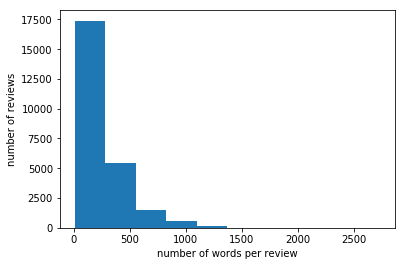

In [48]:
import matplotlib.pyplot as plt
plt.xlabel("number of words per review")
plt.ylabel("number of reviews")
plt.hist(list_of_lengths, bins=10)
plt.show()

As seen above we can see that the data is right skewed and most reviews contain less than 500 words and only small portion of data contain more than that and it keeps decreasing.
So this may indicate that the reviews with word count > a certain value are outliers and may confuse classifiers while they may be special cases (i.e. features obtained from them cannot be generalized to fit the whole distribution)

** Samples **

In [20]:
print("\nexample of a positive sentiment training review:\n\n ",pos_review_train)
print("\nexample of a negative sentiment training review:\n\n ",neg_review_train)
print("\nexample of a positive sentiment testing review:\n\n ",pos_review_test)
print("\nexample of a negative sentiment testing review:\n\n ",neg_review_test)


example of a positive sentiment training review:

   This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending.

example of a negative sentiment training review:

   I found this movie to be a great idea, that didn't deliver. It seems they found a way to build suspense, but couldn't stage their payoffs very well. In one case the police, are on the clock to find the hideout of the kidnappers. They painstakingly go from dentist to dentist to match a

## Back to Preprocessing:

#### Punctuation and Stop-words removal (is,are,the,this ....etc) :

removing any stop words written in capital or small letters and removing punctuations because all of those will just confuse the classifier and are present in all text disregarding its sentiment.

In [21]:
stop_words = list(get_stop_words('en')) 

def remove_stopwords(review):
  filtered_words=[]
  for tokens in review:
    filtered_word=[]
    filtered_word = [word for word in tokens if word.lower() not in stop_words]
    filtered_words.append(filtered_word)
    
  return(filtered_words)
def remove_punctuations(review):
  filtered_words=[]
  filtered=[]
  for tokens in review:
    filtered_word=[]
    for token in tokens:
        if (token.isalpha()== False):
          filtered_word.append(token)
    filtered_words=[x.lower() for x in tokens if x not in  filtered_word]
    filtered.append(filtered_words)
          
    
  return(filtered)



In [22]:
pos_train_tokens=remove_stopwords(pos_reviews_train_list)
pos_train_tokens=remove_punctuations(pos_train_tokens)

neg_train_tokens=remove_stopwords(neg_reviews_train_list)
neg_train_tokens=remove_punctuations(neg_train_tokens)

pos_test_tokens=remove_stopwords(pos_reviews_test_list)
pos_test_tokens=remove_punctuations(pos_test_tokens)

neg_test_tokens=remove_stopwords(neg_reviews_test_list)
neg_test_tokens=remove_punctuations(neg_test_tokens)



**visualization and checking correctness:**

In [23]:
print(pos_train_tokens[0])

['movie', 'special', 'way', 'telling', 'story', 'first', 'found', 'rather', 'odd', 'jumped', 'time', 'idea', 'whats', 'story', 'line', 'although', 'simple', 'still', 'real', 'touching', 'met', 'someone', 'first', 'time', 'fell', 'love', 'completely', 'broke', 'last', 'promoted', 'deadly', 'agony', 'go', 'will', 'never', 'forget', 'kind', 'pain', 'life', 'say', 'rather', 'touched', 'two', 'actor', 'shown', 'great', 'performance', 'showing', 'love', 'characters', 'just', 'wish', 'story', 'happy', 'ending']


as seen above all stop words and punctuations were removed.

**Lemmatization**


Lemmatization is the process of getting the linguistic root of a word,it is better than stemming because for close words produces same output which helps in calculating term frequency in text.

Lemmatization to be done efficiently needs the pos-tag of words which is its position in the sentence and usage (Noun,Verb,Adjective,Adverb).

Also, inside lemmatization function some unhelpful words were removed because of the hypothesis that they are present in all reviews disregarding the sentiment like (movies,films,will,can)

In [24]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
      


def lemmatize_list(list_of_lists_of_tokens):
  lemmatizer = WordNetLemmatizer()
  new_list=[]
  for review in tqdm(list_of_lists_of_tokens):
    new_review=[]
    for token in review:
      
      if(token not in ["movie","film","films","movies","will","can"]):
        new_token=x=lemmatizer.lemmatize(token, get_wordnet_pos(nltk.pos_tag([token])[0][1]))
        new_review.append(new_token)
        
    new_list.append(new_review)
  return new_list
  


In [25]:
pos_train_tokens=lemmatize_list(pos_train_tokens)


neg_train_tokens=lemmatize_list(neg_train_tokens)


pos_test_tokens=lemmatize_list(pos_test_tokens)


neg_test_tokens=lemmatize_list(neg_test_tokens)

100%|██████████| 12500/12500 [03:24<00:00, 61.01it/s]


**visualization and checking correctness:**

In [26]:
#printing text after lemmatization
print(pos_train_tokens[0])

['special', 'way', 'tell', 'story', 'first', 'found', 'rather', 'odd', 'jumped', 'time', 'idea', 'whats', 'story', 'line', 'although', 'simple', 'still', 'real', 'touch', 'met', 'someone', 'first', 'time', 'fell', 'love', 'completely', 'broke', 'last', 'promote', 'deadly', 'agony', 'go', 'never', 'forget', 'kind', 'pain', 'life', 'say', 'rather', 'touch', 'two', 'actor', 'show', 'great', 'performance', 'show', 'love', 'character', 'just', 'wish', 'story', 'happy', 'end']


as seen above the words returned to their roots and it has removed a word "movie" and other words that don't help in detecting sentiment.

**Reconstructing reviews after preprocessing**

After preprocessing has been done there is no need to keep the reviews tokenized and it is time to reconcatenate the words of each review together to have a final list of clean preprocessed reviews ready for feature extraction.


In [27]:
def reconstruct_reviews(list_of_lists_of_tokens):
    list_of_reviews=[]
    for list_of_tokens in tqdm(list_of_lists_of_tokens):
        review=""
        for token in list_of_tokens:
            review+=token+" "
        list_of_reviews.append(review)
    return list_of_reviews


In [28]:
pos_train_reviews=reconstruct_reviews(pos_train_tokens)
neg_train_reviews=reconstruct_reviews(neg_train_tokens)
pos_test_reviews=reconstruct_reviews(pos_test_tokens)
neg_test_reviews=reconstruct_reviews(neg_test_tokens)

100%|██████████| 12500/12500 [00:00<00:00, 61373.35it/s]


**visualization and checking correctness:**

In [29]:
#printing first review after reconstruction
print(pos_train_reviews[0])

special way tell story first found rather odd jumped time idea whats story line although simple still real touch met someone first time fell love completely broke last promote deadly agony go never forget kind pain life say rather touch two actor show great performance show love character just wish story happy end 


### Preparing Training and testing data for the feature extractor and the classifier

In [30]:
#train data is list of positive and negative reviews full after preprocessing and aldo test data
train_data=[]
test_data=[]
train_data.extend(pos_train_reviews)
train_data.extend(neg_train_reviews)
test_data.extend(pos_test_reviews)
test_data.extend(neg_test_reviews)

**visualization and checking correctness:**

In [31]:
#making sure training data is well collected in one list
print(train_data[0])
print("")
print(train_data[12501])

special way tell story first found rather odd jumped time idea whats story line although simple still real touch met someone first time fell love completely broke last promote deadly agony go never forget kind pain life say rather touch two actor show great performance show love character just wish story happy end 

surely one strangest theme history right ed wood impassioned defense glen glenda subject play bridge park avenue set play bohemian play russian speak questionable russian unconvincing accent speak english play restaurant one interested bridge one even despite great cast likely much interested bizarre young paul lukas fine well frank mchugh unlikely ghost writer lukas unlikely russian sunk fetishistic script 


#### Giving Labels:

Giving positve sentiment reviews an integer label "1" and negative sentiment reviews a "0" to help the classifier learn and recongnize different classes and associate some text features to a label sentiment.

In [32]:
#making labels for reviews
train_labels = np.asarray([1]*len(pos_train_reviews) + [0]*len(neg_train_reviews))
test_labels = np.asarray([1]*len(pos_test_reviews) + [0]*len(neg_test_reviews))

**visualization and checking correctness:**

In [33]:
print(train_labels.shape)
print(train_labels[0],train_labels[12501])
print(test_labels.shape)
print(test_labels[0],test_labels[12501])

(25000,)
1 0
(25000,)
1 0


### Feature Extraction (TF-IDF)

TF-IDF (Term Frequency - Inverse Document frequency) is a numerical feature extraction method for text data used to get more information about the text using Bag of words representation.
ngram_range that is given as a parameter is the number of adjacent word associations made and I chose them to be pairs.

TF-IDF method was chosen because Bag of Words methods according to the paper gave the highest results and other newer feature extraction methods like word2vec and doc2vec were not tried.

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
obj = TfidfVectorizer(ngram_range=(1,2),stop_words='english')
#fit transform to learn vocabulary from training data and then assign vectors to them
train_vectors = obj.fit_transform(train_data)
#transform the test data into vectors based on fitting done previously on training data
test_vectors = obj.transform(test_data)

**visualization and checking correctness:**

In [35]:
print("train vector shape:\n",train_vectors.shape)
print("\nThe first train vector:\n",train_vectors[0])
print("\ntest vector shape:\n",test_vectors.shape)
print("\nThe first test vector:\n",test_vectors[0])

train vector shape:
 (25000, 1482787)

The first train vector:
   (0, 1221909)	0.059701768126163374
  (0, 1430921)	0.03877735519161602
  (0, 1303621)	0.053330787115042695
  (0, 1249087)	0.10584343964144066
  (0, 907346)	0.08063763893430748
  (0, 693741)	0.10830005917765659
  (0, 1328104)	0.06304653100654413
  (0, 633254)	0.056472791322568494
  (0, 1440755)	0.110662987492458
  (0, 760205)	0.052803146803002965
  (0, 1187729)	0.07066004023015644
  (0, 1051197)	0.04801518725448591
  (0, 1341992)	0.1334170501880486
  (0, 836690)	0.09013350534097873
  (0, 476732)	0.08628948311228088
  (0, 782356)	0.08181301940421053
  (0, 254127)	0.06081075270377014
  (0, 156254)	0.10090922976723118
  (0, 1022405)	0.0994605242151716
  (0, 315886)	0.09708322454624684
  (0, 30450)	0.11803716036369942
  (0, 504328)	0.0746511235412267
  (0, 709456)	0.05446723026214023
  (0, 932065)	0.08440488126645351
  (0, 747523)	0.04245031173716119
  :	:
  (0, 1342390)	0.16360856890119485
  (0, 836888)	0.15527440864053202
  (

### Supervised Learning

Using Logistic regression and Naive Bayes supervised learning classifiers, fitting them on input training vectors then outputing the classification accuracy as a percentage.

I chose Naive Bayes because it is famous for its good results with text data and Logistic Regression because it was the only classifier allowed in the 2016 kaggle challenge and it produced good results in binary classification.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

#### Logistic Regression

In [36]:
##logistic Regression
from sklearn import linear_model, datasets
logreg = linear_model.LogisticRegression()
logreg.fit(train_vectors, train_labels)
print("Logistic Regression classification accuracy:\n",logreg.score(test_vectors,test_labels)*100,"%")

Logistic Regression classification accuracy:
 86.868 %


#### Naive Bayes

In [37]:
### Naive-bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_vectors, train_labels)
print("Naive Bayes classification accuracy:\n",nb.score(test_vectors,test_labels)*100,"%")

Naive Bayes classification accuracy:
 84.676 %


### Refinement and hyperparameter tuning

Improving results using GridsearchCV where I tune the 'C' hyper parameter in Logistic regression to get better results.
The tuning is done on 10% of the training data : 2500 samples , 1250 positive and 1250 negative to get the best hyperparmeter values and extract the best estimator, then this estimator with best parameters is trained on all training data and accuracy is produced.

Gridsearch is a hyperparameter optimization algorithm that tries all input hyperparameter values given on some portion of data to find best hyperparameters and best model to operate on the data.

In [38]:
#getting 10% of training data and assigning their labels
train_vectors10=train_vectors[11250:13750]
train_labels10=[1] * 1250
train_labels10.extend([0]*1250)


trying different values for C hyperparameter ([0.1,1,10,25,50,100,1000,10000]) to find the best of them

In [39]:
from sklearn import grid_search
#values of C hyper parameter to try in grid search
parameters = {'C':[0.1,1,10,25,50,100,1000,10000]}
#making a new logistic regression model
logreg = linear_model.LogisticRegression()
grid_search = grid_search.GridSearchCV(logreg, parameters)
#fitting grid search with 10% of training data to find best parameters
grid_search.fit(train_vectors10, train_labels10)
# extracting estimator with best parameters
logclf=grid_search.best_estimator_
logclf_CV=grid_search.best_estimator_

/home/kareem/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kareem/.local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [40]:
print('Best params for accuracy:')
print(grid_search.best_params_)
print("\nestimator:\n")
print(logclf)
logclf.fit(train_vectors,train_labels)
print("\nLogistic Regression classification accuracy:\n",logclf.score(test_vectors,test_labels)*100,"%")

Best params for accuracy:
{'C': 50}

estimator:

LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Logistic Regression classification accuracy:
 87.928 %


as seen above, the best hyperparameter value was C=50 and the best estimator with this parameter value gave  87.928 % accuracy compared to  86.868 % before tuning.

** Tuning Naive Bayes**

Trying different alpha (smoothening) values: [0,0.3,0.5,0.7,1] using gridsearch

In [41]:
from sklearn.model_selection import GridSearchCV
#values of C hyper parameter to try in grid search
parameters = {'alpha':[0,0.3,0.5,0.7,1]}
#making a new naive bayes model
nb = MultinomialNB()
grid_search = GridSearchCV(nb, parameters)
#fitting grid search with 10% of training data to find best parameters
grid_search.fit(train_vectors10, train_labels10)
# extracting estimator with best parameters
clf=grid_search.best_estimator_

/home/kareem/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kareem/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/kareem/.local/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [42]:
print('Best params for accuracy:')
print(grid_search.best_params_)
print("\nestimator:\n")
print(clf)
clf.fit(train_vectors,train_labels)
print("\nNaive Bayes classification accuracy:\n",clf.score(test_vectors,test_labels)*100,"%")

Best params for accuracy:
{'alpha': 0.5}

estimator:

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

Naive Bayes classification accuracy:
 84.63199999999999 %


as seen above, the best hyperparameter value found by grid search was alpha=0.5 and the best estimator with this parameter value gave 84.63199999999999% accuracy compared to 84.676 % before tuning, so this shows that tuning on 10% failed to extract best alpha parameter and that the higher smoothening value gave higher accuracy (by a small value).

#### K-Folds Cross Validation

Besides hyperparameter tuning using Grid Search, K-Folds Cross Validation is now used to validate the robustness of the model by making several train-validation splits withing data and train the model on them and test on different validation sets, to detect overfitting and underfitting signs.

In [43]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(logclf_CV, train_vectors, train_labels, cv=5)

In [44]:
print(scores*100)
print("Mean Accuracy: %0.2f  (+/- %0.2f deviation) " % (scores.mean()*100, scores.std() * 2))

[88.78 88.24 88.9  89.44 89.24]
Mean Accuracy: 88.92  (+/- 0.01 deviation) 


As seen above when used K-Folds Cross Validation on the training set with our best model that came out of gridsearchCV hyperparameter tuning, high accuracies were obtained on training set even higher than ones obtained before on testing test but not much higher which shows very good generalization and low tendency towards overfitting and underfitting.

In [45]:
#another method for K-folds cross validation
# from sklearn.model_selection import KFold
# mean=0
# kf = KFold(n_splits=5,shuffle=True,random_state=1995)
# for train, test in kf.split(train_vectors):
#     print('train: %s, test: %s' % (train_vectors[train].shape, train_vectors[test].shape))
#     logclf_CV.fit(train_vectors[train],train_labels[train])
#     x=logclf_CV.score(train_vectors[test],train_labels[test])
#     mean+=x
#     print("accuracy",x*100,"%")
# print("mean K-Folds cross validation score:",mean/5*100,"%")


### Algorithms and techniques 
after each step there is a breif description of each Algorithm and Technique used followed by reason of usage.

** Naive Bayes ** is a probabilistic classifier that uses the probability of appearance of features in certain classes to predict the correct class of a given input but it makes an assumption of having independence between features.It is a conditional probability model given a problem instance to be classified, represented by a vector X=(x1,x2...xn) representing some n features (independent variables), it assigns to this instance probabilities P(C_k/ x1,x2...xn) for each of K possible outcomes or classes C_k.

We Classify and give a label to the review according to the class that has the highest conditional probability given the features as conditions.


** Logistic Regression ** is an algorithm mostly used for binary classification by fitting a the best curve possible through tuning linear equation coefficients to make a decision boundary between classes through searching for minimal mean squared loss.

Logistic regression uses an equation as the representation, input values (x) are combined linearly using weights or coefficient values (b1):

y = e^(b0 + b1*x) / (1 + e^(b0 + b1*x)).

Where y is the predicted output, b0 is the bias or intercept term and b1 is the coefficient for the single input value (x). Each column in your input data has an associated b coefficient (a constant real value) that must be learned from your training data.

(resource: https://machinelearningmastery.com/logistic-regression-for-machine-learning/ )

A good thing about Logistic Regression beside the fact that it runs in little time in this task is the fact that it supports online learning (there are implementations of it that support it), this means that we can add more training examples if they become available in the future without needing to rerun the algorithm on the whole dataset again.
(resource: “A Family of Online Boosting Algorithms” by Babenco et al.)


# Results

### Model Evaluation and Validation

The tuned C parameter of logistic regression is the inverse of regulization strength (higher values of C correspond to less regularization) which means on increasing the value of C we allow the equation to get to higher degrees in order to fit the problem better which results in more complexity.
So by tuning the best value for C found that gives best accuracy was 50 as compare to the default value 1 which means we need to decrease regularizarion and allow more degrees of freedom to make better classification.
But in comparing results we find that the accuracy was not improved by much (about 1.2%) so this improvement can be removed if we wanted less complexity.

The alpha parameter for naive bayes is additive (Laplace/Lidstone) smoothing parameter: 0 for no smoothing and 1 for full smoothing.
Smoothening aims to reduce the effect of rare words in classification, for example: if a word "hot" is found only in one negative sentiment review , we want to reduce the effect of it in classification of all reviews containing this word as negative just because of it.
The accuracy values show that the default smoothening value (alpha=1) gave better results by a little amount.

### Justification

The best accuracy obtained was that of logistic regression equivalent to  87.928 %, which is much better than the random chance benchmark (50%) and very close to the other stated benchmark by Maas et al. ( 88.89%) only off by 1%.
So this solution succeeds to solve the problem to a good extent and can classify most text sentiments of movie reviews especially that it had been trained on 25k different reviews.

# Conclusion

### Free-Form Visualization

In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[10906  1594]
 [ 2248 10252]]


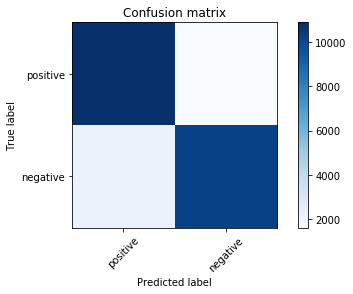

In [49]:
from sklearn.metrics import confusion_matrix
test_predicted=clf.predict(test_vectors)
cm=confusion_matrix(test_labels, test_predicted)
plot_confusion_matrix(cm, labels=["positive","negative"])
print(cm)

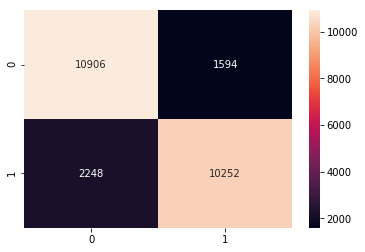

In [50]:
#trying seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(test_labels, test_predicted), annot = True, fmt = '')

As seen above by plotting the confusion matrix  we see that predicting positive sentiment is the best performance of the model is in predicting True-positive labels and there is some sort of diagonal symmetry within the matrix, so the model is balanced and does not tend towards one type of misclassification over others by a big value.

### Reflection

The project summary is that in order to classify the sentiment of reviews I needed to preprocess the text first to remove any words that don't help in classification and then extract numerical features based on word frequency in documents to give weights to words and finally use supervised learning to process those features and make decision boundaries to classify any test document given its numerical features.

What I found challenging about the project was understanding word embeddings and extraction of features from text but it was a thing worth learning.
Another challenging thing was all the documentation required and explanations of each step which is so time consuming but it is necessary to produce any readable output that is valuable to others.

In the process of coding the only thing I struggled with was in the tuning step where I used train_test_split() function of scikit learn to get 10% of data to use for tuning but the tuning wouldn't improve accuracy based on those splits and hyperparameters did not change but when I hand split the 10% I wanted the tuning worked and accuracy improved and this is probably because I chose some baised unshuffled data but they seemed to work for tuning, so it was not fully automated.

### Improvement

I think what can be improved is trying another word embedding models like word2vec and doc2vec to extract features in other ways and maybe use other classification methods like deep learning ones (CNNs or RNNs)

**Dataset credits and copyrights:**

InProceedings{maas-EtAl:2011:ACL-HLT2011,
  author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
  
  title     = {Learning Word Vectors for Sentiment Analysis},
  
  booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},
  
  month     = {June},
  
  year      = {2011},
  
  address   = {Portland, Oregon, USA},
  
  publisher = {Association for Computational Linguistics},
  
  pages     = {142--150},
  
  url       = {http://www.aclweb.org/anthology/P11-1015}
}


References

Potts, Christopher. 2011. On the negativity of negation. In Nan Li and
David Lutz, eds., Proceedings of Semantics and Linguistic Theory 20,
636-659.
